In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz

### 1.)  Exploratory Data Analysis (EDA)

In [8]:
df = pd.read_csv(r"titanic/train.csv")

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [10]:
print(df.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


##### Using Histogram plotting distribution of age

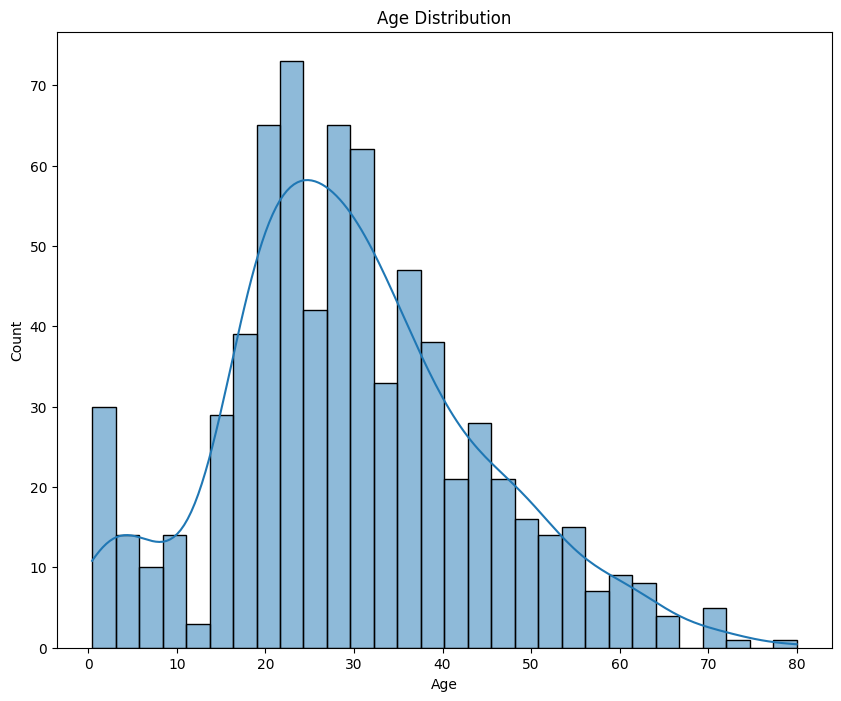

In [12]:
plt.figure(figsize=(10,8))
sns.histplot(df['age'].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

##### Using Bar Plot Comparing survival rate across different passenger classes (Pclass)

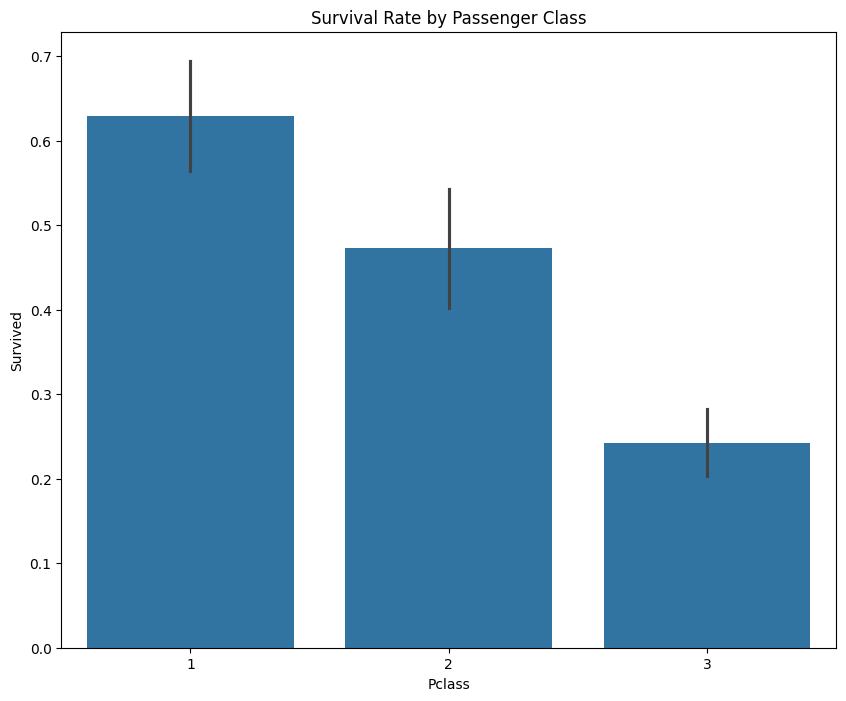

In [14]:
plt.figure(figsize=(10, 8))
sns.barplot(x='pclass', y='survived', data=df)
plt.title("Survival Rate by Passenger Class")
plt.show()

##### Using Heat Map Displaying correlation between numerical features

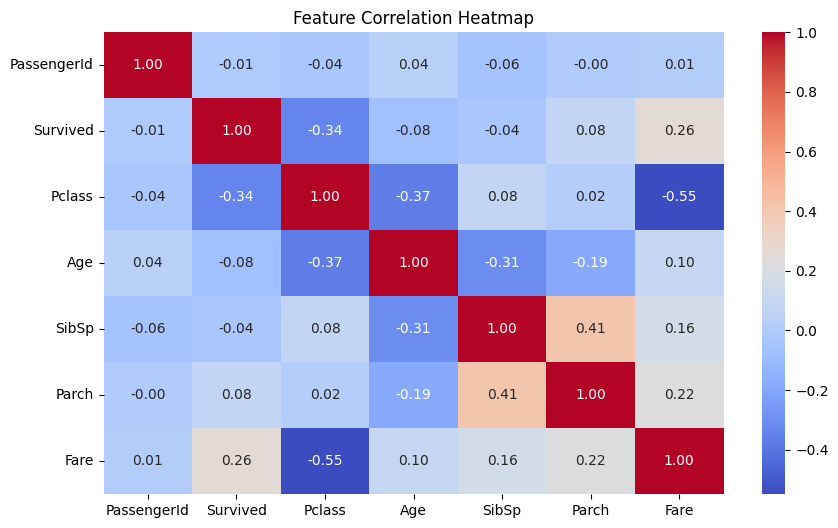

In [17]:
plt.figure(figsize=(10, 6))
x = df.select_dtypes(include=['number'])
sns.heatmap(x.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

### 2.) Handling Missing Values

In [24]:
# Extract titles from names
df['Title'] = df['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [25]:
# Map titles to median ages
title_age_map = df.groupby('Title')['age'].median().to_dict()
df['age'] = df['age'].fillna(df['Title'].map(title_age_map))

In [26]:
# Fill missing Fare with median fare of the same Pclass
df['Fare'] = df.groupby('pclass')['fare'].transform(lambda x: x.fillna(x.median()))

In [27]:
# Fill missing Embarked with most common value
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [36]:
df.columns = df.columns.str.lower()
print(df.columns)

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'embarked', 'title'],
      dtype='object')


In [ ]:
#Droping the cabin due more missing values
df.drop(columns=['Cabin'], inplace=True)

### 3.) Feature Engineering

In [38]:
df['FamilySize'] = df['sibsp'] + df['parch'] + 1

In [40]:
def categorize_age(age):
    if age < 13:
        return "Child"
    elif age < 18:
        return "Teen"
    elif age < 60:
        return "Adult"
    else:
        return "Senior"

df['AgeCategory'] = df['age'].apply(categorize_age)

In [42]:
def categorize_family(size):
    if size == 1:
        return "Single"
    elif size <= 4:
        return "Small Family"
    else:
        return "Large Family"

df['FamilyCategory'] = df['FamilySize'].apply(categorize_family)

### 4.) One-Hot Encoding

In [44]:
df = pd.get_dummies(df, columns=['sex', 'embarked', 'pclass', 'FamilyCategory', 'AgeCategory'], drop_first=True)

In [49]:
X = df[['sex_male', 'pclass_2', 'pclass_3', 'age', 'fare', 'FamilySize']]
y = df['survived']

### 5.) Decision Tree Classifier

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

In [52]:
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

In [53]:
# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy:", accuracy)

Decision Tree Accuracy: 0.8156424581005587


In [56]:
# Visualize Decision Tree
dot_data = export_graphviz(model, out_file=None, feature_names=X.columns, class_names=['Not Survived', 'Survived'],filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("titanic_tree")

'titanic_tree.pdf'

### 6.) Hyperparameter Tuning

In [57]:
from sklearn.model_selection import GridSearchCV

In [88]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [92]:
dt = DecisionTreeClassifier(random_state=42)

In [93]:
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [90]:
best_dt = grid_search.best_estimator_
print("Best Parameters for Decision Tree:", grid_search.best_params_)

Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


### 7.) Compare Decision Tree vs. Random Forest

In [97]:
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [98]:
y_pred_dt = best_dt.predict(X_test)

In [99]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [100]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [101]:
y_pred_rf = rf.predict(X_test)

In [96]:
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Decision Tree Accuracy: 0.8044692737430168
Random Forest Accuracy: 0.8268156424581006
